In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, BatchNormalization, Activation, Dropout

from keras.models import Model
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical

Defining a VAE architecture

In [ ]:

def build_vae(input_shape, latent_dim, complexity,dropout_rate ):
    # Encoder
    inputs = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(inputs)
    x = Dense(complexity, activation='relu')(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # Sampling function
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    # Reparameterization Trick
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # Decoder
    decoder_h = Dense(complexity, activation='relu')
    decoder_mean = Dense(np.prod(input_shape), activation='sigmoid')
    h = decoder_h(z)
    x_decoded_mean = decoder_mean(h)
    #x_decoded_mean = Reshape(input_shape)(x_decoded_mean)
    #x_decoded_mean = Reshape((input_shape[0], input_shape[1], 1))(x_decoded_mean)
    x_decoded_mean = Reshape((input_shape[0], input_shape[1], input_shape[2]))(x_decoded_mean)
    x_decoded_mean = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x_decoded_mean)
    x_decoded_mean = BatchNormalization()(x_decoded_mean)
    x_decoded_mean = Dropout(dropout_rate)(x_decoded_mean)
    x_decoded_mean = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x_decoded_mean)
    x_decoded_mean = BatchNormalization()(x_decoded_mean)
    x_decoded_mean = Dropout(dropout_rate)(x_decoded_mean)
    x_decoded_mean = Conv2D(input_shape[2], kernel_size=(3, 3), activation='sigmoid', padding='same')(x_decoded_mean)

    # VAE Model
    vae = Model(inputs, x_decoded_mean)

    # Loss
    #xent_loss = K.mean(K.binary_crossentropy(K.flatten(inputs), K.flatten(x_decoded_mean)))
    #xent_loss = K.sum(K.binary_crossentropy(K.flatten(inputs), K.flatten(x_decoded_mean)), axis=-1)
    xent_loss = np.prod(input_shape) * binary_crossentropy(Flatten()(inputs), Flatten()(x_decoded_mean))
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)

    return vae

Dataset loading and preprocessing function

In [ ]:
def load_data(dataset):
    if dataset == 'mnist':
        (x_train, _), (x_test, _) = mnist.load_data()
        input_shape = (28, 28, 1)
    elif dataset == 'cifar10':
        (x_train, _), (x_test, _) = cifar10.load_data()
        input_shape = (32, 32, 3)

    # Normalize data
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.

    # Reshape data
    x_train = np.reshape(x_train, (len(x_train), *input_shape))
    x_test = np.reshape(x_test, (len(x_test), *input_shape))

    return x_train, x_test, input_shape

Training the model and plotting loss function

In [ ]:
# Training function
def train_vae(vae, x_train, x_test, epochs, batch_size):
    vae.compile(optimizer='rmsprop')
    vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

# Plot loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Generating images

In [ ]:
def generate_images(vae, x_test):
    decoded_imgs = vae.predict(x_test)
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original Images
        ax = plt.subplot(2, n, i + 1)
        if x_test.shape[-1] == 1:
            plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        else:
            plt.imshow(x_test[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Original')

        # Reconstructed Images
        ax = plt.subplot(2, n, i + 1 + n)
        if decoded_imgs.shape[-1] == 1:
            plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        else:
            plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Reconstructed')
    plt.show()

Setting Up  general parameters

In [ ]:
epochs = 10
batch_size = 128
dropout_rate = 0.3

 Anaylsis on CIFAR 10

In [ ]:
dataset = 'cifar10'

Behaviour of latent dimensionality values

With latent_dim=5 and complexity=128
Epoch 1/10
391/391 [==============================] - 8s 13ms/step - loss: 2016.6600 - val_loss: 2026.8651
Epoch 2/10
391/391 [==============================] - 4s 10ms/step - loss: 1930.7168 - val_loss: 1930.1523
Epoch 3/10
391/391 [==============================] - 5s 12ms/step - loss: 1922.8617 - val_loss: 2012.1810
Epoch 4/10
391/391 [==============================] - 4s 11ms/step - loss: 1918.9061 - val_loss: 1913.3773
Epoch 5/10
391/391 [==============================] - 4s 11ms/step - loss: 1915.6797 - val_loss: 1931.6216
Epoch 6/10
391/391 [==============================] - 5s 12ms/step - loss: 1913.6409 - val_loss: 1918.8549
Epoch 7/10
391/391 [==============================] - 5s 12ms/step - loss: 1911.8885 - val_loss: 1913.7222
Epoch 8/10
391/391 [==============================] - 4s 11ms/step - loss: 1910.2421 - val_loss: 1915.0746
Epoch 9/10
391/391 [==============================] - 4s 11ms/step - loss: 1909.1125 - val_loss: 1937.7081


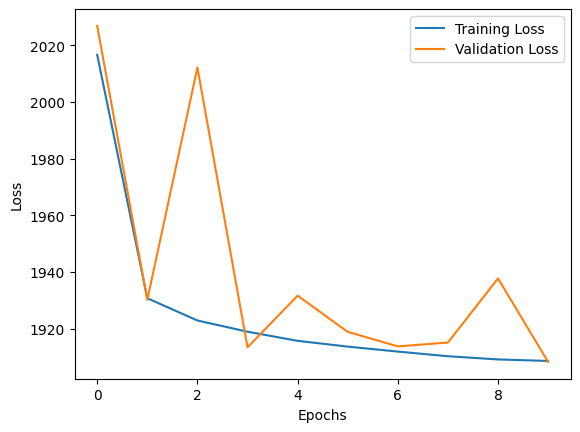

313/313 [==============================] - 1s 3ms/step


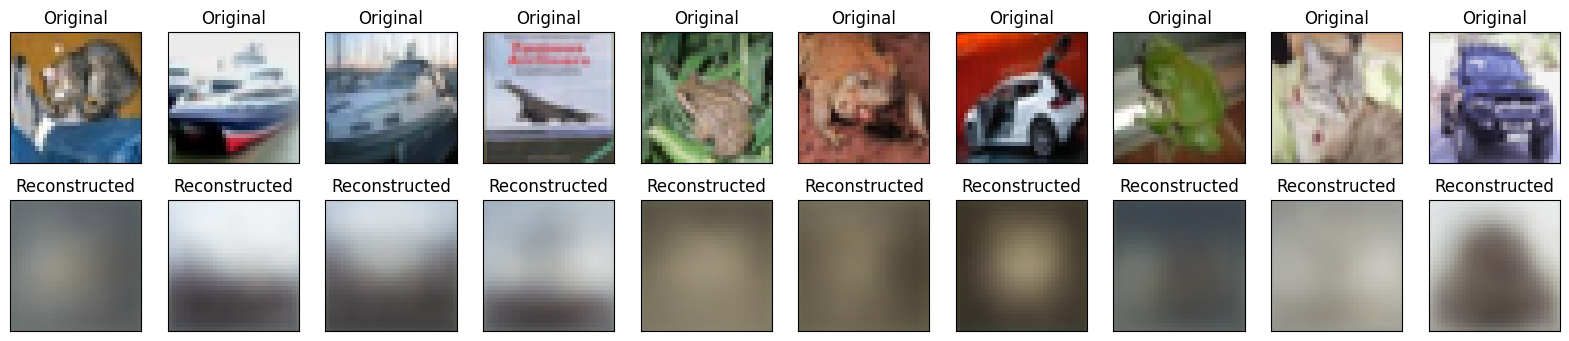

With latent_dim=10 and complexity=128
Epoch 1/10
391/391 [==============================] - 7s 13ms/step - loss: 2012.4399 - val_loss: 2019.1250
Epoch 2/10
391/391 [==============================] - 5s 12ms/step - loss: 1909.2062 - val_loss: 1906.7128
Epoch 3/10
391/391 [==============================] - 4s 11ms/step - loss: 1893.5323 - val_loss: 1886.9200
Epoch 4/10
391/391 [==============================] - 5s 12ms/step - loss: 1886.3254 - val_loss: 1917.4226
Epoch 5/10
391/391 [==============================] - 5s 12ms/step - loss: 1882.7396 - val_loss: 1881.5696
Epoch 6/10
391/391 [==============================] - 4s 11ms/step - loss: 1880.1013 - val_loss: 1889.4369
Epoch 7/10
391/391 [==============================] - 5s 12ms/step - loss: 1878.2660 - val_loss: 1875.1996
Epoch 8/10
391/391 [==============================] - 5s 12ms/step - loss: 1876.2830 - val_loss: 1883.6167
Epoch 9/10
391/391 [==============================] - 5s 12ms/step - loss: 1875.1517 - val_loss: 1881.0237

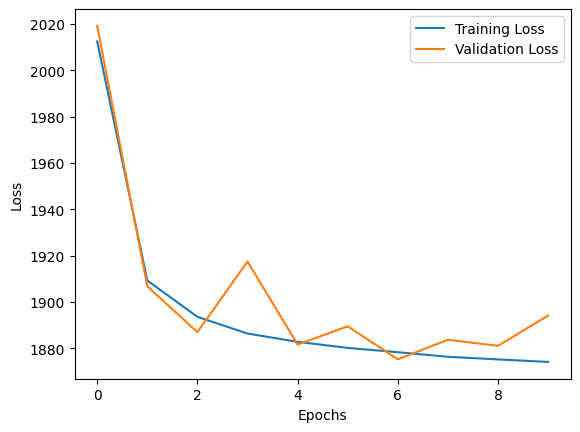

313/313 [==============================] - 1s 3ms/step


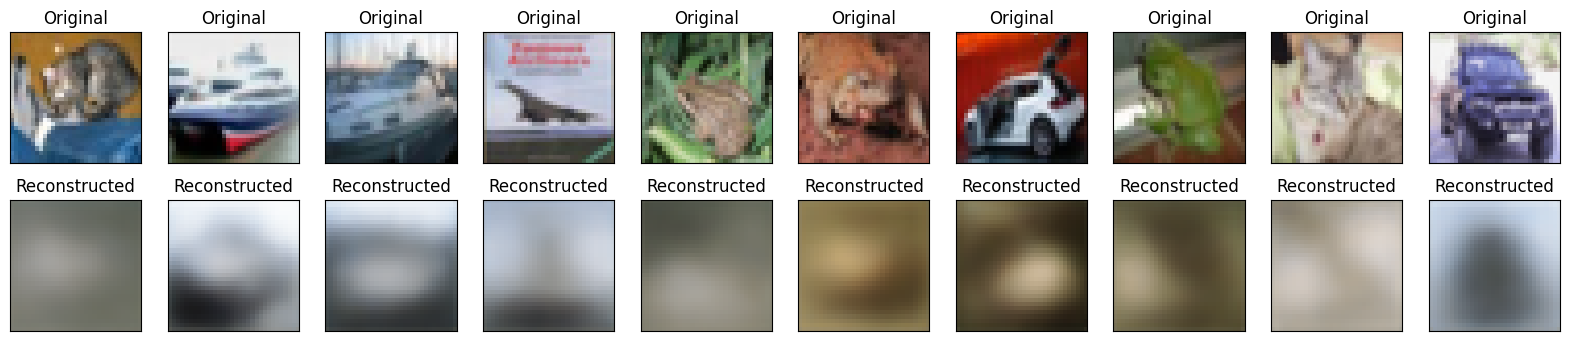

With latent_dim=50 and complexity=128
Epoch 1/10
391/391 [==============================] - 8s 13ms/step - loss: 2042.8378 - val_loss: 2022.3032
Epoch 2/10
391/391 [==============================] - 5s 12ms/step - loss: 1934.5900 - val_loss: 1925.4805
Epoch 3/10
391/391 [==============================] - 5s 12ms/step - loss: 1908.6760 - val_loss: 1910.0870
Epoch 4/10
391/391 [==============================] - 4s 11ms/step - loss: 1896.0377 - val_loss: 1886.7206
Epoch 5/10
391/391 [==============================] - 5s 12ms/step - loss: 1887.0177 - val_loss: 1895.0631
Epoch 6/10
391/391 [==============================] - 5s 12ms/step - loss: 1880.6792 - val_loss: 1934.8846
Epoch 7/10
391/391 [==============================] - 4s 11ms/step - loss: 1875.6132 - val_loss: 1879.5305
Epoch 8/10
391/391 [==============================] - 4s 11ms/step - loss: 1871.6450 - val_loss: 1876.5184
Epoch 9/10
391/391 [==============================] - 5s 12ms/step - loss: 1868.3728 - val_loss: 1873.4288

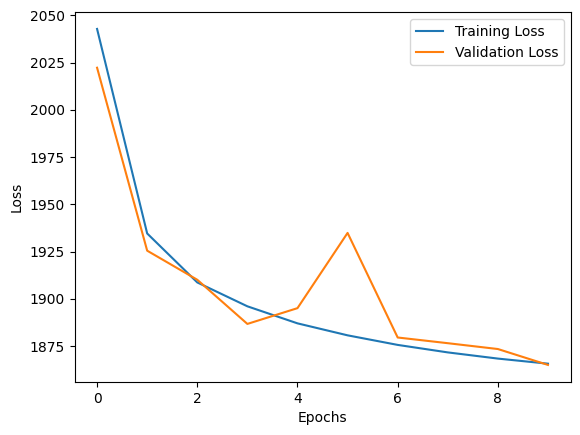

313/313 [==============================] - 1s 3ms/step


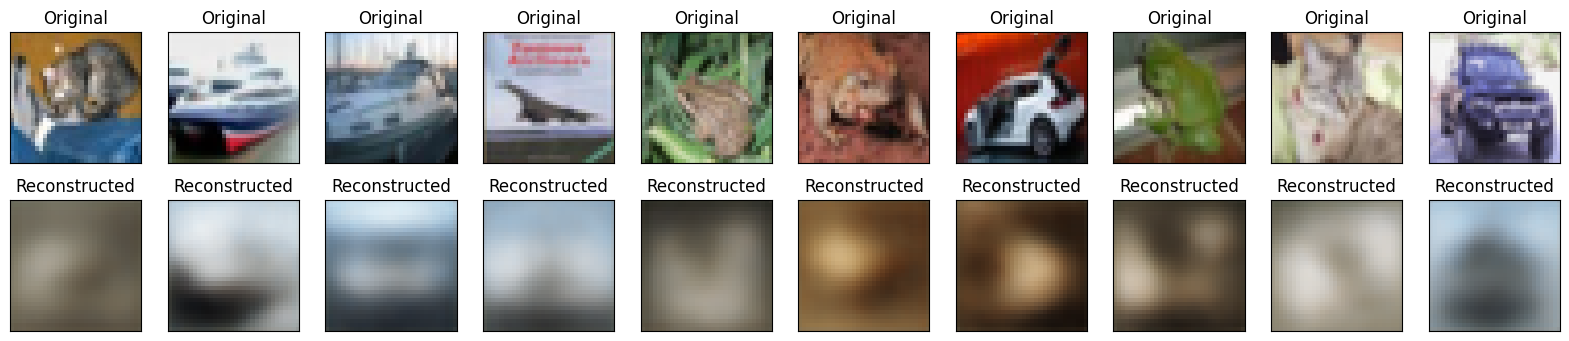

With latent_dim=100 and complexity=128
Epoch 1/10
391/391 [==============================] - 8s 14ms/step - loss: 2043.5927 - val_loss: 2035.2490
Epoch 2/10
391/391 [==============================] - 5s 11ms/step - loss: 1949.7181 - val_loss: 1936.7893
Epoch 3/10
391/391 [==============================] - 4s 11ms/step - loss: 1927.5422 - val_loss: 1945.6023
Epoch 4/10
391/391 [==============================] - 5s 13ms/step - loss: 1909.9203 - val_loss: 1916.8428
Epoch 5/10
391/391 [==============================] - 5s 12ms/step - loss: 1899.9521 - val_loss: 1900.6958
Epoch 6/10
391/391 [==============================] - 4s 11ms/step - loss: 1892.6515 - val_loss: 1888.7373
Epoch 7/10
391/391 [==============================] - 5s 13ms/step - loss: 1886.6504 - val_loss: 1883.8518
Epoch 8/10
391/391 [==============================] - 5s 12ms/step - loss: 1882.8101 - val_loss: 1888.2271
Epoch 9/10
391/391 [==============================] - 5s 12ms/step - loss: 1880.8013 - val_loss: 1882.730

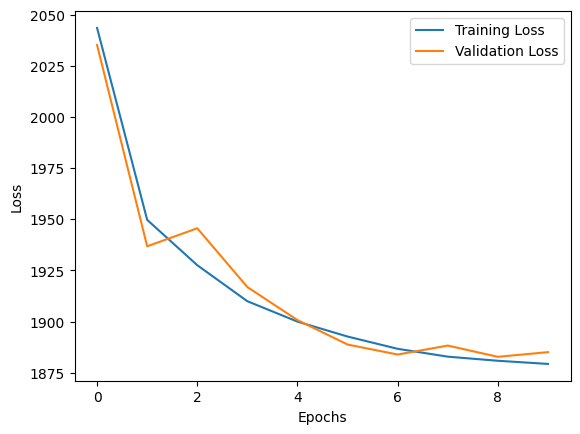

313/313 [==============================] - 1s 3ms/step


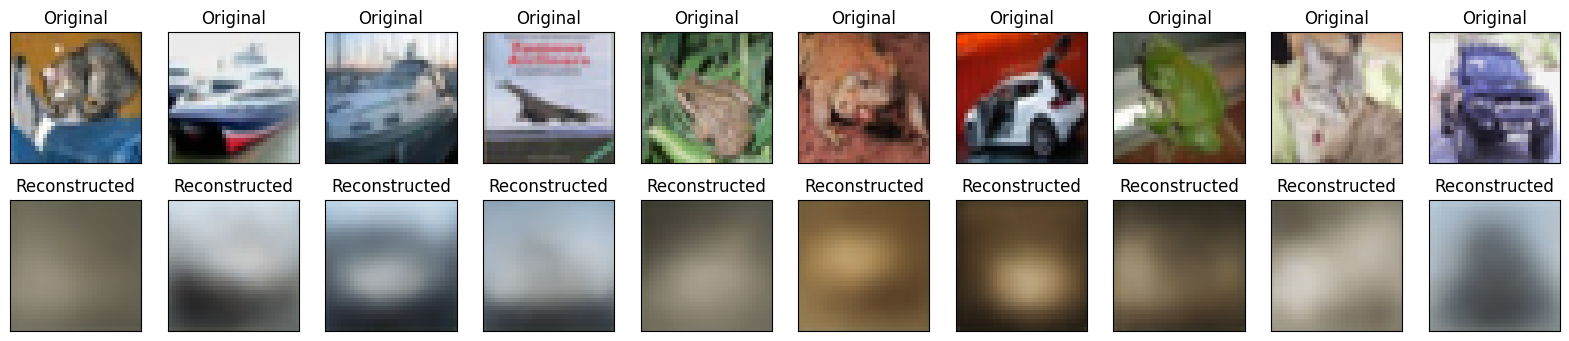

In [ ]:
latent_dim_values = [5, 10, 50, 100]
complexity = 128

x_train, x_test, input_shape = load_data(dataset)
for latent_dim in latent_dim_values:
      print(f"With latent_dim={latent_dim} and complexity={complexity}")

      vae = build_vae(input_shape, latent_dim, complexity, dropout_rate)
      train_vae(vae, x_train, x_test, epochs, batch_size)

      # Plot loss
      plot_loss(vae.history)

      # Generate and plot images
      generate_images(vae, x_test)

Behaviour of complexity values

With latent_dim=50 and complexity=32
Epoch 1/10
391/391 [==============================] - 7s 12ms/step - loss: 2122.9968 - val_loss: 2095.8369
Epoch 2/10
391/391 [==============================] - 5s 12ms/step - loss: 2074.9446 - val_loss: 2081.0037
Epoch 3/10
391/391 [==============================] - 5s 11ms/step - loss: 2071.8169 - val_loss: 2071.6384
Epoch 4/10
391/391 [==============================] - 4s 10ms/step - loss: 2065.7686 - val_loss: 2066.0010
Epoch 5/10
391/391 [==============================] - 5s 12ms/step - loss: 2044.7179 - val_loss: 2040.1139
Epoch 6/10
391/391 [==============================] - 5s 12ms/step - loss: 1996.9415 - val_loss: 1984.9723
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 1982.5072 - val_loss: 1985.1086
Epoch 8/10
391/391 [==============================] - 4s 10ms/step - loss: 1977.2670 - val_loss: 1974.3010
Epoch 9/10
391/391 [==============================] - 5s 12ms/step - loss: 1973.2096 - val_loss: 2027.9086


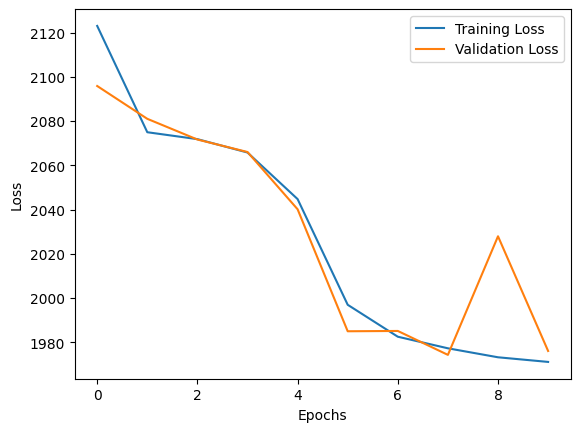

313/313 [==============================] - 1s 3ms/step


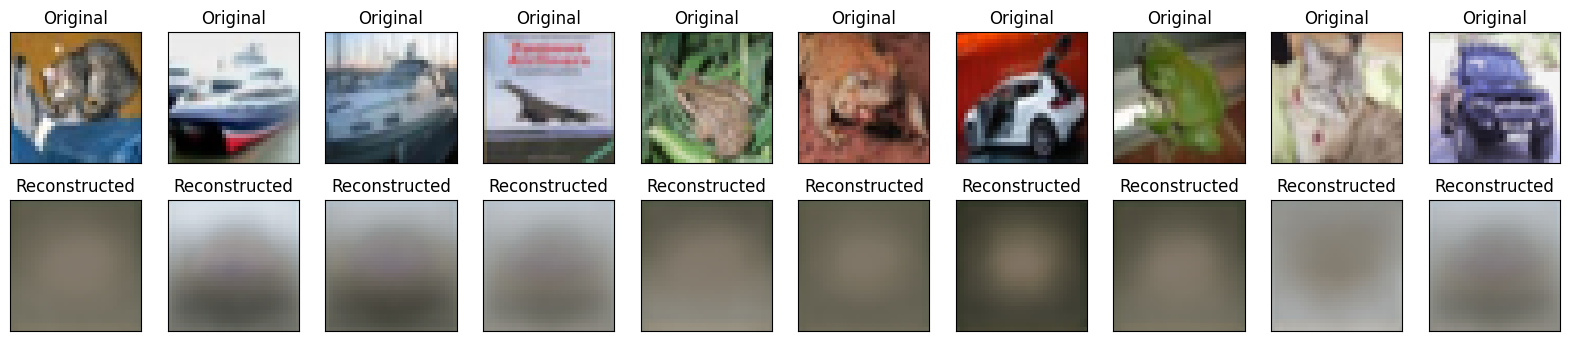

With latent_dim=50 and complexity=64
Epoch 1/10
391/391 [==============================] - 8s 14ms/step - loss: 2055.9131 - val_loss: 2052.6646
Epoch 2/10
391/391 [==============================] - 4s 11ms/step - loss: 1969.4131 - val_loss: 1971.5886
Epoch 3/10
391/391 [==============================] - 5s 13ms/step - loss: 1954.3636 - val_loss: 1969.4325
Epoch 4/10
391/391 [==============================] - 4s 11ms/step - loss: 1945.9979 - val_loss: 1948.9972
Epoch 5/10
391/391 [==============================] - 4s 11ms/step - loss: 1939.9296 - val_loss: 1939.2169
Epoch 6/10
391/391 [==============================] - 4s 11ms/step - loss: 1934.8142 - val_loss: 1934.5787
Epoch 7/10
391/391 [==============================] - 4s 11ms/step - loss: 1931.7705 - val_loss: 1932.7545
Epoch 8/10
391/391 [==============================] - 4s 11ms/step - loss: 1930.0126 - val_loss: 1939.1244
Epoch 9/10
391/391 [==============================] - 4s 11ms/step - loss: 1928.6226 - val_loss: 1972.0287


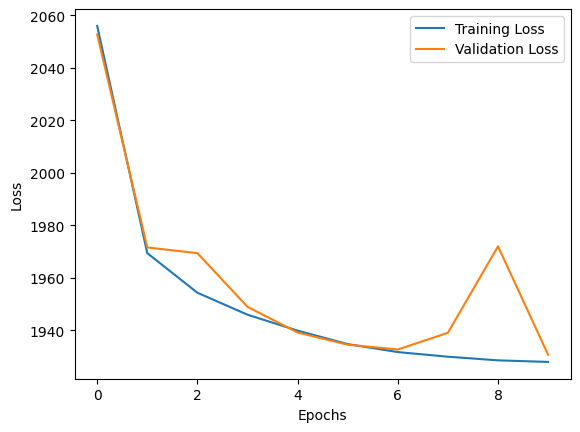

313/313 [==============================] - 1s 3ms/step


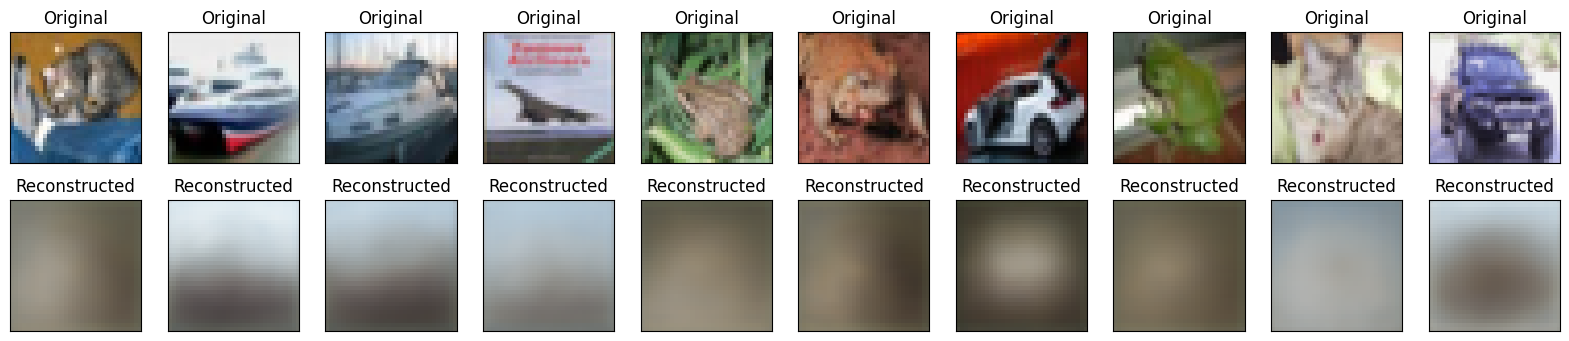

With latent_dim=50 and complexity=128
Epoch 1/10
391/391 [==============================] - 7s 14ms/step - loss: 2033.9487 - val_loss: 2021.1046
Epoch 2/10
391/391 [==============================] - 4s 11ms/step - loss: 1935.0365 - val_loss: 1962.5538
Epoch 3/10
391/391 [==============================] - 4s 11ms/step - loss: 1909.6573 - val_loss: 1920.7603
Epoch 4/10
391/391 [==============================] - 5s 13ms/step - loss: 1896.7253 - val_loss: 1898.5032
Epoch 5/10
391/391 [==============================] - 4s 11ms/step - loss: 1888.6901 - val_loss: 1890.1691
Epoch 6/10
391/391 [==============================] - 4s 11ms/step - loss: 1881.8940 - val_loss: 1897.5131
Epoch 7/10
391/391 [==============================] - 5s 12ms/step - loss: 1876.3931 - val_loss: 1886.2876
Epoch 8/10
391/391 [==============================] - 5s 12ms/step - loss: 1872.0647 - val_loss: 1879.8008
Epoch 9/10
391/391 [==============================] - 4s 11ms/step - loss: 1869.0098 - val_loss: 1863.6652

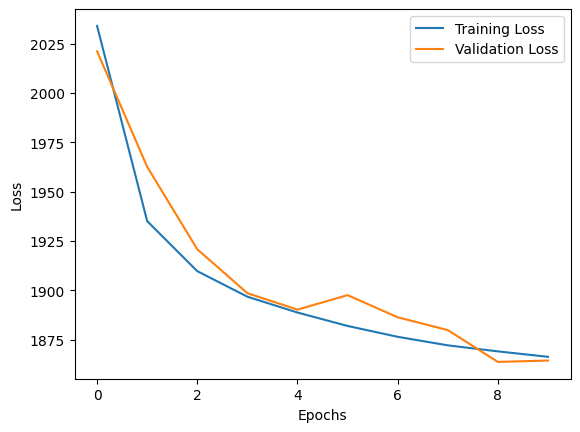

313/313 [==============================] - 1s 4ms/step


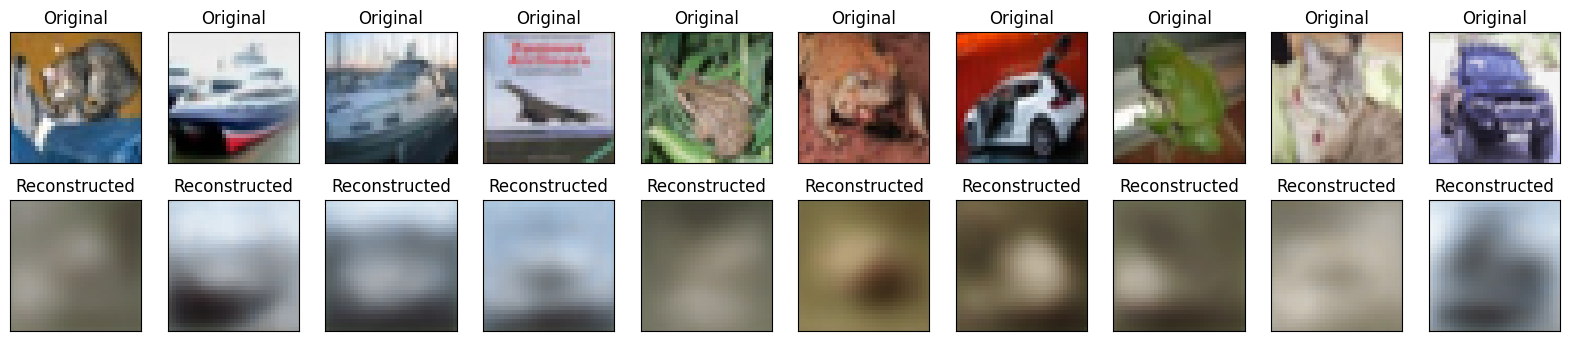

With latent_dim=50 and complexity=256
Epoch 1/10
391/391 [==============================] - 7s 13ms/step - loss: 2062.2239 - val_loss: 2017.2551
Epoch 2/10
391/391 [==============================] - 5s 12ms/step - loss: 1930.9319 - val_loss: 1923.6667
Epoch 3/10
391/391 [==============================] - 4s 11ms/step - loss: 1902.0171 - val_loss: 1897.4972
Epoch 4/10
391/391 [==============================] - 4s 11ms/step - loss: 1888.9442 - val_loss: 1918.9790
Epoch 5/10
391/391 [==============================] - 5s 13ms/step - loss: 1880.7290 - val_loss: 1879.8000
Epoch 6/10
391/391 [==============================] - 5s 12ms/step - loss: 1874.1277 - val_loss: 1907.1897
Epoch 7/10
391/391 [==============================] - 4s 11ms/step - loss: 1869.1018 - val_loss: 1866.6667
Epoch 8/10
391/391 [==============================] - 5s 12ms/step - loss: 1865.4794 - val_loss: 1864.8317
Epoch 9/10
391/391 [==============================] - 5s 12ms/step - loss: 1862.4924 - val_loss: 1880.7601

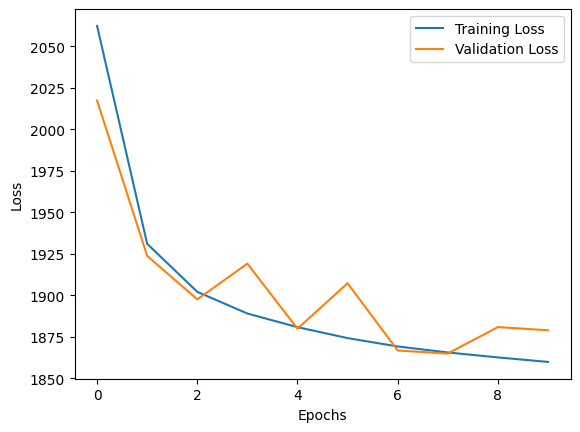

313/313 [==============================] - 1s 3ms/step


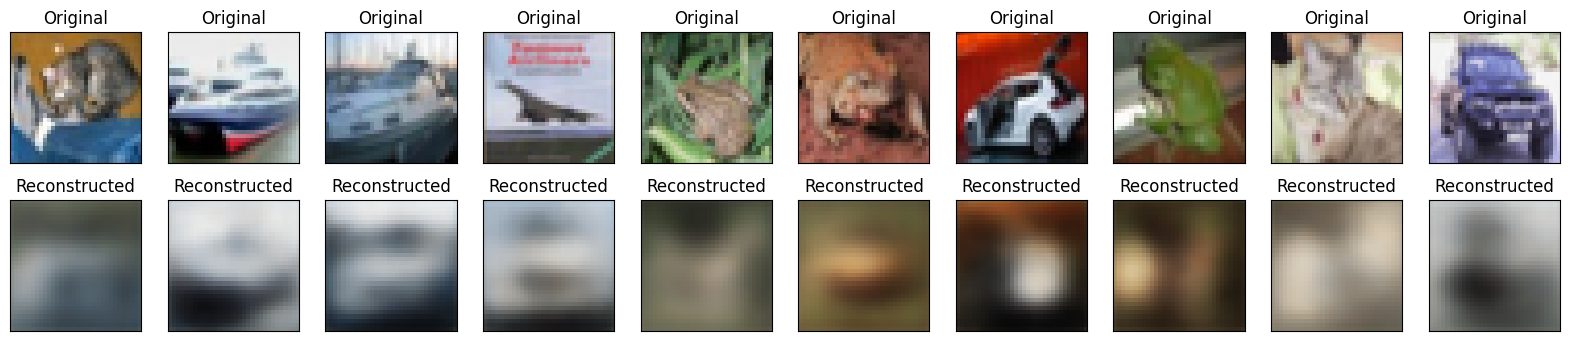

In [ ]:
latent_dim = 50
complexity_values = [32, 64, 128, 256]

x_train, x_test, input_shape = load_data(dataset)
for complexity in complexity_values:
    print(f"With latent_dim={latent_dim} and complexity={complexity}")

    vae = build_vae(input_shape, latent_dim, complexity, dropout_rate)
    train_vae(vae, x_train, x_test, epochs, batch_size)

    # Plot loss
    plot_loss(vae.history)

    # Generate and plot images
    generate_images(vae, x_test)

Anaylsis on MNIST

In [ ]:
dataset = 'mnist'

Behaviour of latent dimensionality values

With latent_dim=5 and complexity=128
Epoch 1/10
469/469 [==============================] - 7s 10ms/step - loss: 168.5584 - val_loss: 197.9774
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 140.2501 - val_loss: 137.0632
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 135.5056 - val_loss: 132.6974
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 132.7629 - val_loss: 181.2656
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 130.8634 - val_loss: 157.8663
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 129.4916 - val_loss: 150.9144
Epoch 7/10
469/469 [==============================] - 5s 10ms/step - loss: 128.4445 - val_loss: 141.6467
Epoch 8/10
469/469 [==============================] - 4s 9ms/step - loss: 127.6346 - val_loss: 134.2842
Epoch 9/10
469/469 [==============================] - 4s 9ms/step - loss: 126.9538 - val_loss: 130.7380
Epoch 10/10
469/469 [===

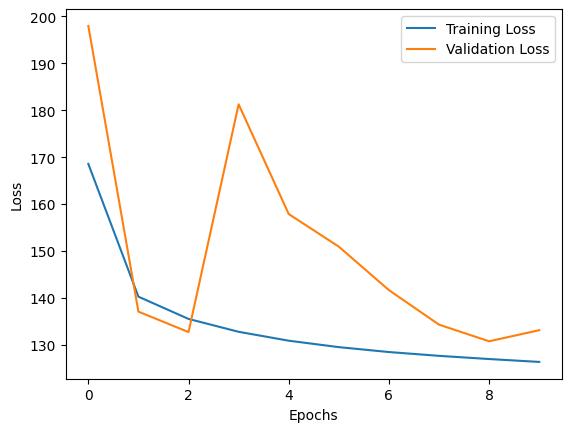

313/313 [==============================] - 1s 3ms/step


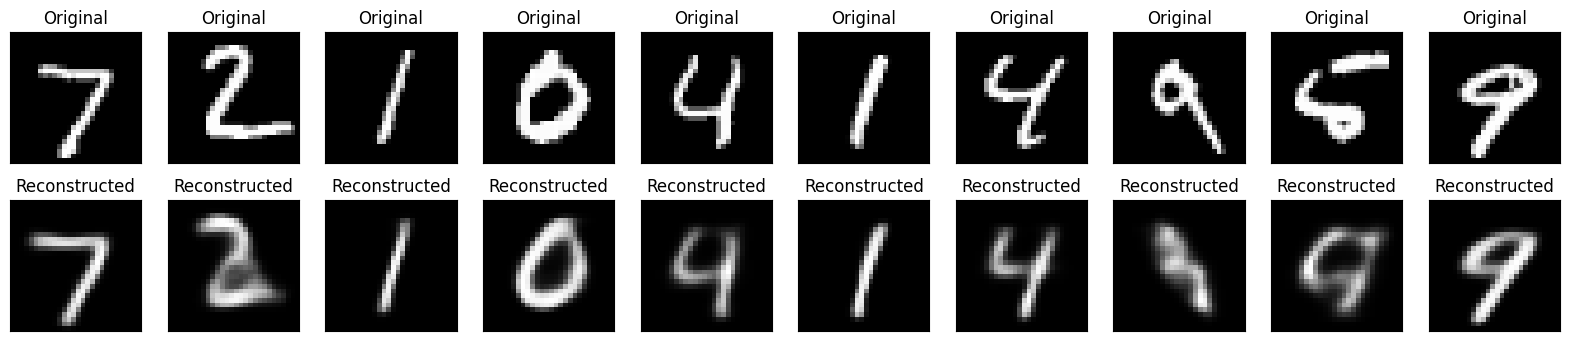

With latent_dim=10 and complexity=128
Epoch 1/10
469/469 [==============================] - 7s 10ms/step - loss: 163.3436 - val_loss: 163.7518
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 127.2693 - val_loss: 207.3108
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 121.9967 - val_loss: 122.8371
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 118.9961 - val_loss: 122.1239
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - loss: 117.2364 - val_loss: 119.0455
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 115.9021 - val_loss: 131.0690
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 114.8807 - val_loss: 124.2580
Epoch 8/10
469/469 [==============================] - 5s 10ms/step - loss: 114.0912 - val_loss: 118.9851
Epoch 9/10
469/469 [==============================] - 4s 9ms/step - loss: 113.3650 - val_loss: 114.0918
Epoch 10/10
469/469 [=

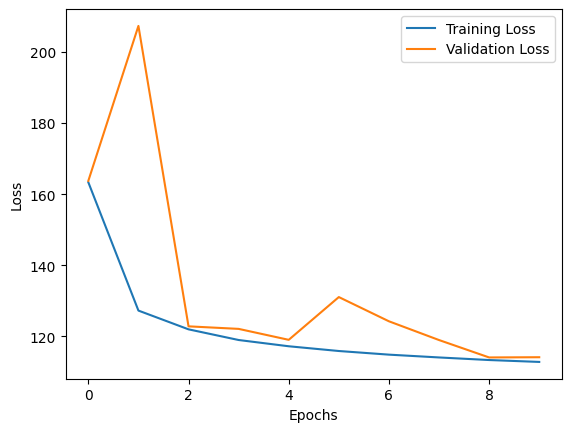

313/313 [==============================] - 1s 3ms/step


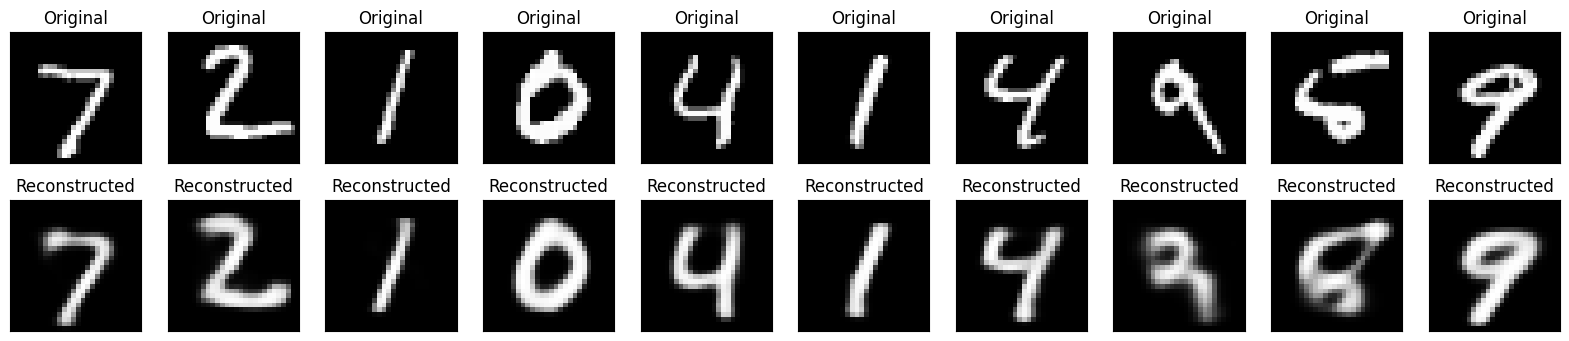

With latent_dim=50 and complexity=128
Epoch 1/10
469/469 [==============================] - 6s 9ms/step - loss: 169.6911 - val_loss: 169.4708
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 130.7791 - val_loss: 126.9712
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 123.1613 - val_loss: 120.7622
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 118.8703 - val_loss: 119.5106
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 116.1878 - val_loss: 111.8671
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 114.2609 - val_loss: 112.4192
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 112.9491 - val_loss: 110.9687
Epoch 8/10
469/469 [==============================] - 4s 9ms/step - loss: 111.8889 - val_loss: 108.3545
Epoch 9/10
469/469 [==============================] - 5s 11ms/step - loss: 111.1350 - val_loss: 108.5828
Epoch 10/10
469/469 [==

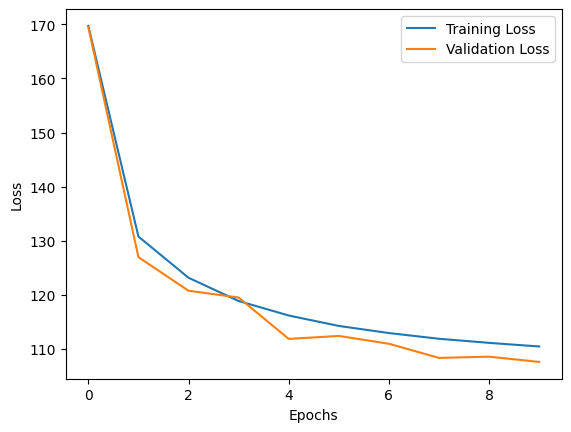

313/313 [==============================] - 1s 2ms/step


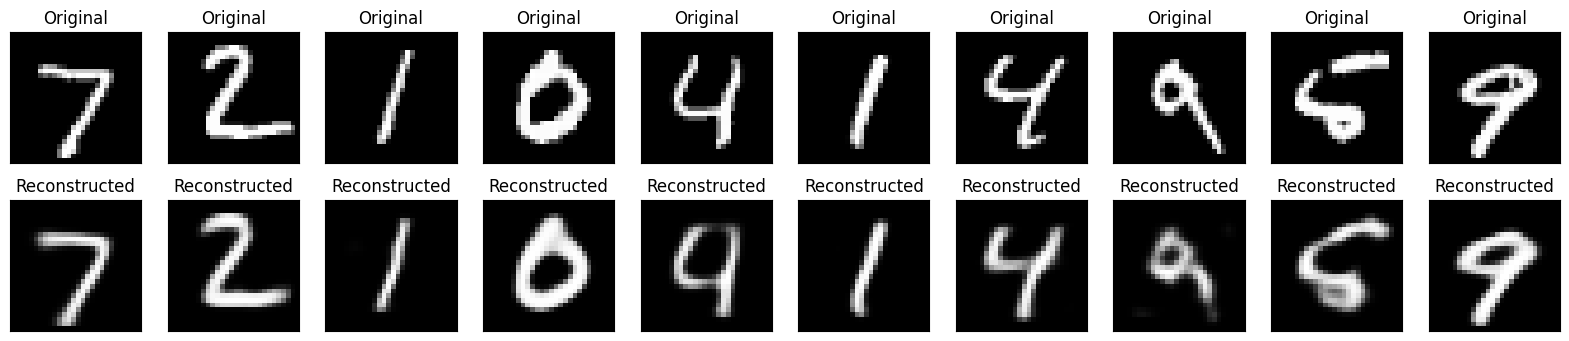

With latent_dim=100 and complexity=128
Epoch 1/10
469/469 [==============================] - 7s 11ms/step - loss: 176.0936 - val_loss: 176.1869
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 139.4910 - val_loss: 132.1349
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 129.8449 - val_loss: 128.3934
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - loss: 123.3146 - val_loss: 124.0810
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 118.9638 - val_loss: 117.4305
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 115.9261 - val_loss: 112.4531
Epoch 7/10
469/469 [==============================] - 5s 10ms/step - loss: 113.9330 - val_loss: 112.0480
Epoch 8/10
469/469 [==============================] - 4s 10ms/step - loss: 112.5453 - val_loss: 109.8373
Epoch 9/10
469/469 [==============================] - 4s 9ms/step - loss: 111.7156 - val_loss: 108.8988
Epoch 10/10
469/469 [

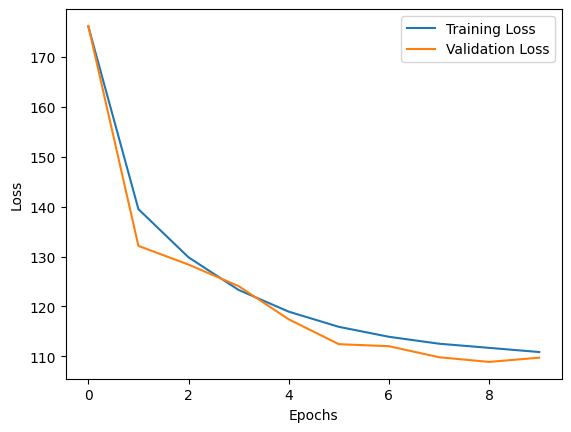

313/313 [==============================] - 1s 4ms/step


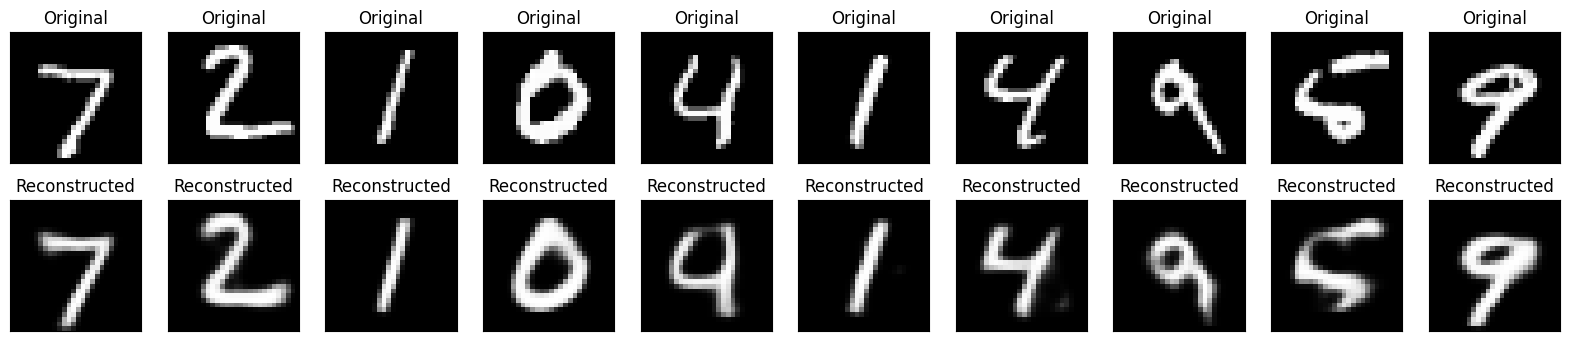

In [ ]:
latent_dim_values = [5, 10, 50, 100]
complexity = 128

x_train, x_test, input_shape = load_data(dataset)
for latent_dim in latent_dim_values:
      print(f"With latent_dim={latent_dim} and complexity={complexity}")

      vae = build_vae(input_shape, latent_dim, complexity, dropout_rate)
      train_vae(vae, x_train, x_test, epochs, batch_size)

      # Plot loss
      plot_loss(vae.history)

      # Generate and plot images
      generate_images(vae, x_test)

Behaviour of complexity values

With latent_dim=50 and complexity=32
Epoch 1/10
469/469 [==============================] - 6s 9ms/step - loss: 181.5191 - val_loss: 194.0984
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 146.8917 - val_loss: 138.0818
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 138.0828 - val_loss: 131.3731
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 131.6658 - val_loss: 125.7413
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 126.7455 - val_loss: 120.3328
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 123.4910 - val_loss: 121.0509
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 121.2036 - val_loss: 116.3473
Epoch 8/10
469/469 [==============================] - 4s 9ms/step - loss: 119.5630 - val_loss: 116.1576
Epoch 9/10
469/469 [==============================] - 5s 10ms/step - loss: 118.4737 - val_loss: 113.9117
Epoch 10/10
469/469 [===

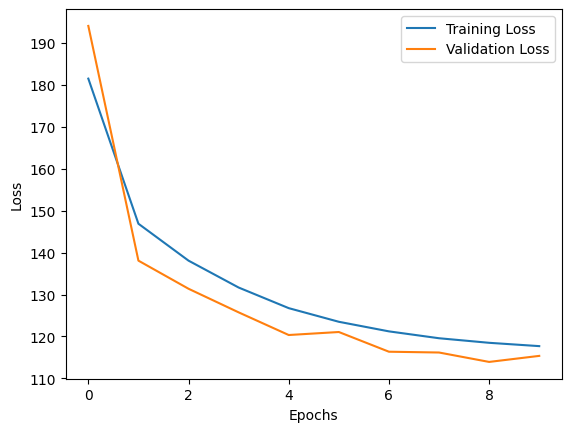

313/313 [==============================] - 1s 3ms/step


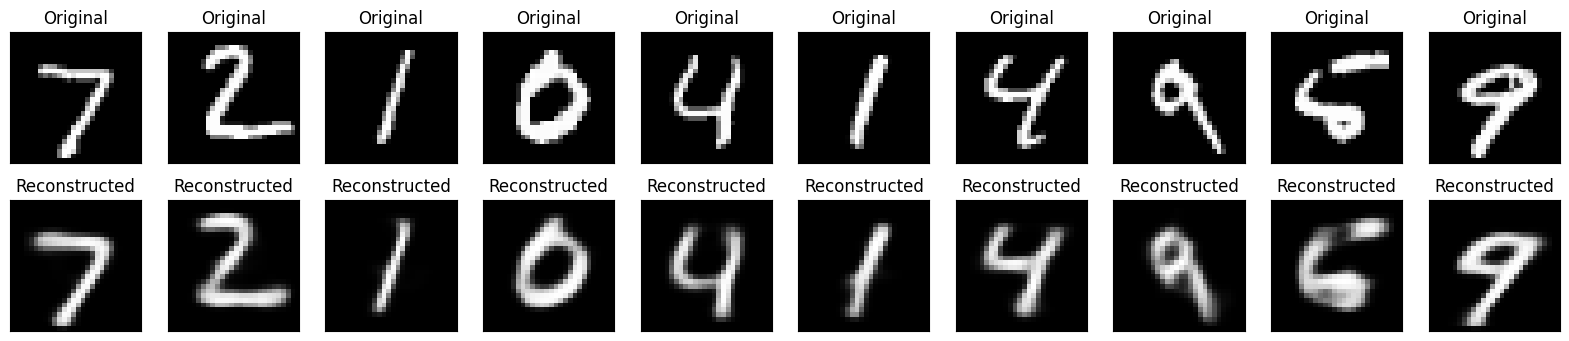

With latent_dim=50 and complexity=64
Epoch 1/10
469/469 [==============================] - 7s 11ms/step - loss: 176.3728 - val_loss: 171.3031
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 137.7330 - val_loss: 140.6403
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 129.2799 - val_loss: 123.0008
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - loss: 123.9210 - val_loss: 123.4993
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 120.5337 - val_loss: 116.4388
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 118.3871 - val_loss: 128.0537
Epoch 7/10
469/469 [==============================] - 5s 11ms/step - loss: 116.8584 - val_loss: 117.2100
Epoch 8/10
469/469 [==============================] - 4s 9ms/step - loss: 115.7093 - val_loss: 115.4071
Epoch 9/10
469/469 [==============================] - 4s 9ms/step - loss: 114.8209 - val_loss: 113.8005
Epoch 10/10
469/469 [==

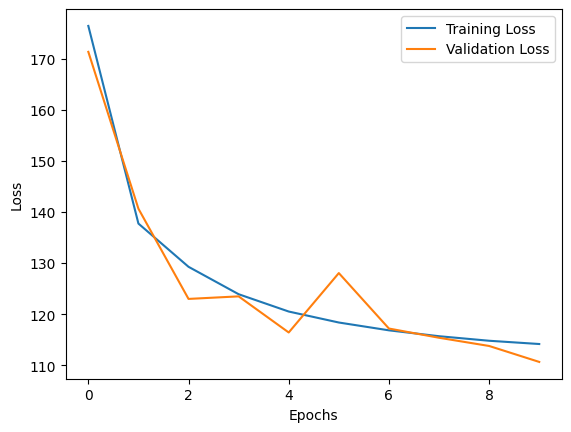

313/313 [==============================] - 1s 3ms/step


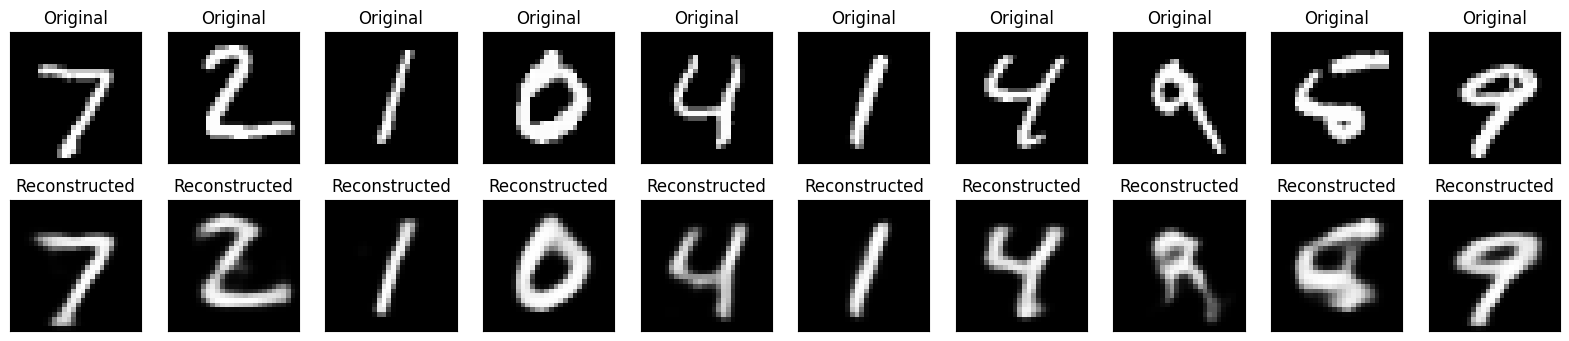

With latent_dim=50 and complexity=128
Epoch 1/10
469/469 [==============================] - 7s 9ms/step - loss: 171.1412 - val_loss: 164.1979
Epoch 2/10
469/469 [==============================] - 5s 10ms/step - loss: 131.0713 - val_loss: 123.8776
Epoch 3/10
469/469 [==============================] - 4s 9ms/step - loss: 122.6987 - val_loss: 117.1393
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 118.2094 - val_loss: 115.8995
Epoch 5/10
469/469 [==============================] - 5s 10ms/step - loss: 115.5184 - val_loss: 112.1872
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - loss: 113.8706 - val_loss: 112.2154
Epoch 7/10
469/469 [==============================] - 4s 9ms/step - loss: 112.5746 - val_loss: 109.7943
Epoch 8/10
469/469 [==============================] - 5s 10ms/step - loss: 111.5707 - val_loss: 110.4482
Epoch 9/10
469/469 [==============================] - 5s 10ms/step - loss: 110.7370 - val_loss: 108.3863
Epoch 10/10
469/469 [

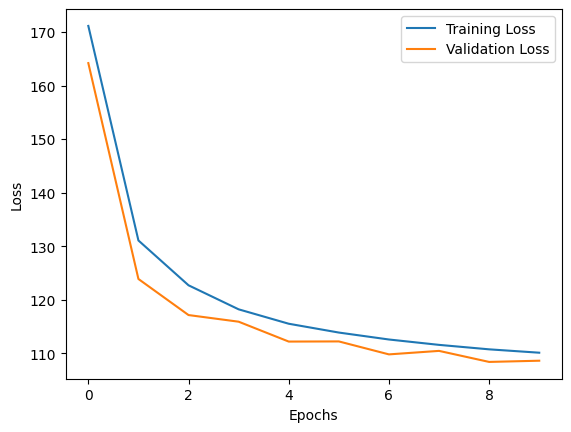

313/313 [==============================] - 1s 3ms/step


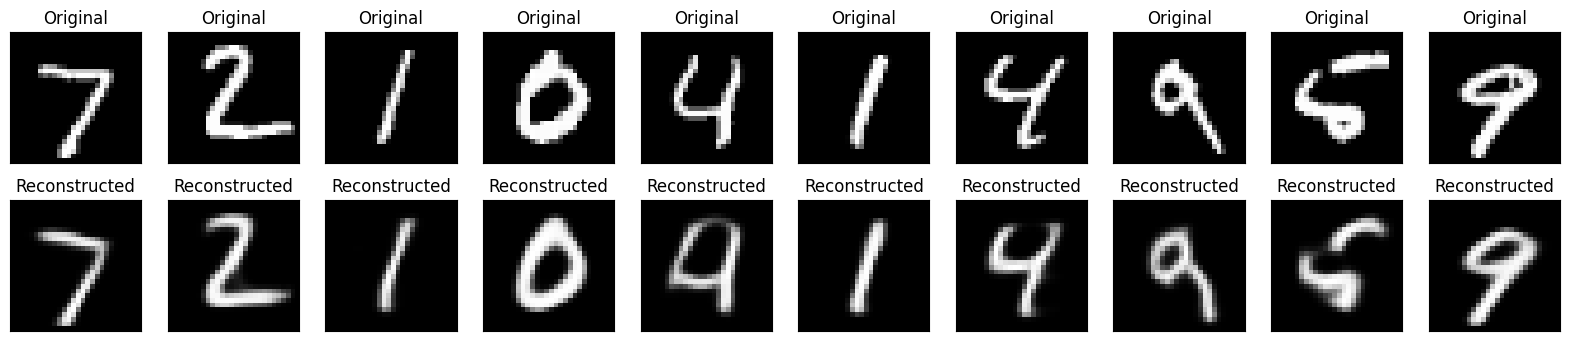

With latent_dim=50 and complexity=256
Epoch 1/10
469/469 [==============================] - 8s 10ms/step - loss: 166.8721 - val_loss: 160.6484
Epoch 2/10
469/469 [==============================] - 4s 9ms/step - loss: 127.2865 - val_loss: 119.2173
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 119.4874 - val_loss: 116.5616
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - loss: 115.5685 - val_loss: 112.3369
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 113.2232 - val_loss: 109.6471
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 111.5870 - val_loss: 109.2367
Epoch 7/10
469/469 [==============================] - 5s 10ms/step - loss: 110.3095 - val_loss: 107.8653
Epoch 8/10
469/469 [==============================] - 4s 9ms/step - loss: 109.3968 - val_loss: 106.8825
Epoch 9/10
469/469 [==============================] - 4s 9ms/step - loss: 108.6757 - val_loss: 106.3499
Epoch 10/10
469/469 [=

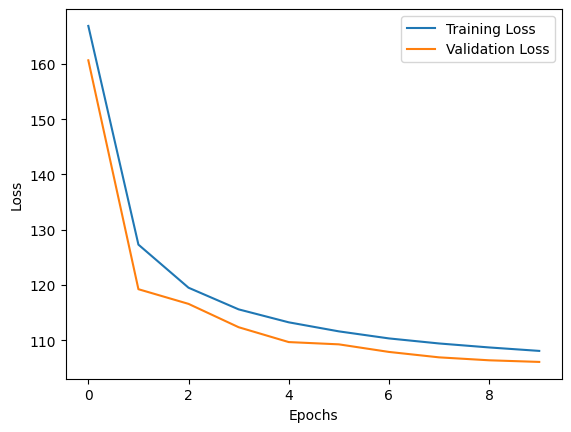

313/313 [==============================] - 1s 3ms/step


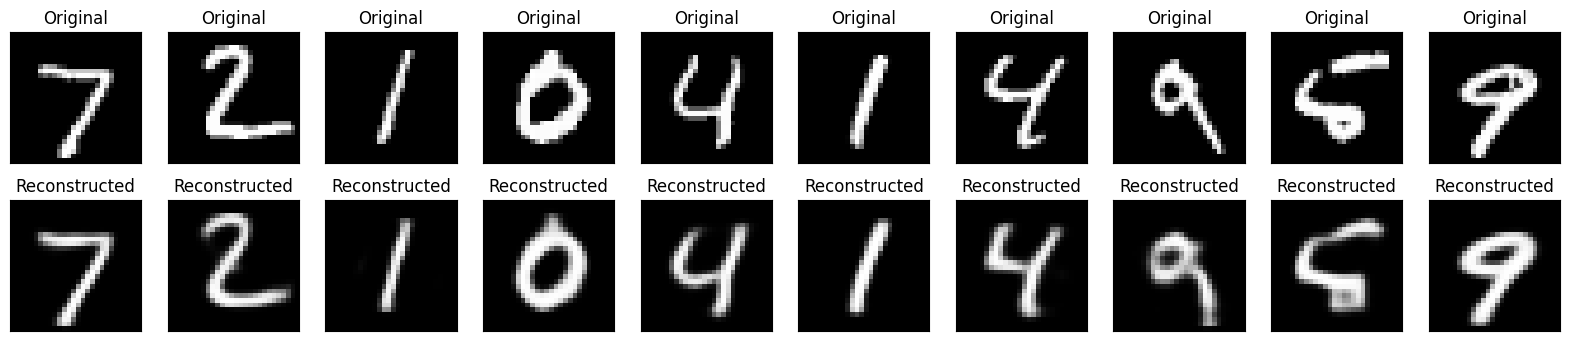

In [ ]:
latent_dim = 50
complexity_values = [32, 64, 128, 256]

x_train, x_test, input_shape = load_data(dataset)
for complexity in complexity_values:
    print(f"With latent_dim={latent_dim} and complexity={complexity}")

    vae = build_vae(input_shape, latent_dim, complexity, dropout_rate)
    train_vae(vae, x_train, x_test, epochs, batch_size)

    # Plot loss
    plot_loss(vae.history)

    # Generate and plot images
    generate_images(vae, x_test)